In [230]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from scipy.stats import ttest_ind
from statsmodels.tsa.seasonal import seasonal_decompose


# Load Data

In [231]:
calls = pd.read_csv('/Users/pendovka/Desktop/Data/Central Intake Service Queue Data.csv')
calls['Date'] = pd.to_datetime(calls['Date'])
calls.set_index('Date', inplace=True)  

In [232]:
occupancy = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2023.csv')

occupancy['OCCUPANCY_DATE'] = pd.to_datetime(occupancy['OCCUPANCY_DATE'])
occupancy.set_index('_id', inplace=True, drop=True)

occupancy.set_index('OCCUPANCY_DATE', inplace=True)
monthly_average_occupancy_rate = occupancy['OCCUPANCY_RATE_BEDS'].resample('MS').mean()

In [233]:
shelter_flow = pd.read_csv('/Users/pendovka/Desktop/Data/toronto-shelter-system-flow.csv')
shelter_flow.rename(columns={'date(mmm-yy)': 'Date'}, inplace=True)
shelter_flow['Date'] = pd.to_datetime(shelter_flow['Date'], format='%b-%y')
shelter_flow = shelter_flow.set_index('Date')

In [234]:
calls_full = pd.read_csv('/Users/pendovka/Desktop/Data/Central Intake Call Wrap-Up Codes Data.csv')
calls_full['Date'] = pd.to_datetime(calls_full['Date'])
calls_full.set_index('Date', inplace=True)
calls_full.rename(columns={'Code 3B - Shelter Space Unavailable - Individuals/Couples': 'shelter_unavailable_ind'}, inplace=True)
calls_full.rename(columns={'Total calls handled': 'total_calls_handled'}, inplace=True)


# Initial Correlation Analysis

In [235]:
average_daily_calls_unavailable = calls_full['shelter_unavailable_ind'].resample('MS').mean()
average_daily_total_calls = calls_full['total_calls_handled'].resample('MS').mean().rename('average_daily_total_calls')

monthly_calls = pd.merge(average_daily_calls_unavailable, average_daily_total_calls, on='Date', how='inner')
monthly_calls['unavailable_ratio'] = monthly_calls['shelter_unavailable_ind'] / monthly_calls['average_daily_total_calls']

shelter_flow = shelter_flow[shelter_flow['population_group'] == 'All Population']

average_daily_unmatched = calls['Unmatched callers'].resample('MS').mean().rename('average_daily_unmatched_callers')
monthly_calls_merge = pd.merge(monthly_calls, average_daily_unmatched , on= 'Date', how='inner')

In [236]:
merged_calls_flow_monthly = pd.merge(monthly_calls_merge, shelter_flow, left_index=True, right_index=True, how='inner')

merged_calls_flow_monthly = merged_calls_flow_monthly[merged_calls_flow_monthly.index.year < 2024]

merged_calls_flow_monthly.reset_index(inplace=True)

merged_calls_flow_monthly = merged_calls_flow_monthly[['Date', 'average_daily_total_calls', 'average_daily_unmatched_callers', 'newly_identified', 'actively_homeless', 'became_inactive', 'returned_to_shelter']]

correlation_calls_newlyhomeless = merged_calls_flow_monthly[['average_daily_unmatched_callers', 'newly_identified']].corr().iloc[0, 1]
correlation_calls_activelyhomeless = merged_calls_flow_monthly[['average_daily_unmatched_callers', 'actively_homeless']].corr().iloc[0, 1]
correlation_calls_inactive = merged_calls_flow_monthly[['average_daily_unmatched_callers', 'became_inactive']].corr().iloc[0, 1]

print(f"Correlation between the number of unmatched callers and newly homeless: {correlation_calls_newlyhomeless:.2f}")
print(f"Correlation between the number of unmatched callers and actively homeless: {correlation_calls_activelyhomeless:.2f}")
print(f"Correlation between the number of unmatched callers and inactive homeless: {correlation_calls_inactive:.2f}")

Correlation between the number of unmatched callers and newly homeless: 0.35
Correlation between the number of unmatched callers and actively homeless: 0.65
Correlation between the number of unmatched callers and inactive homeless: -0.35


# Merge all occupancy tables

In [957]:
occupancy2024 = pd.read_csv('/Users/pendovka/Desktop/Data/Daily shelter overnight occupancy.csv')
occupancy2023 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2023.csv')
occupancy2022 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2022.csv')
occupancy2021 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2021.csv')

occupancy2021['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2021['OCCUPANCY_DATE'], format='%y-%m-%d').dt.strftime('%Y-%m-%d')
occupancy2022['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2022['OCCUPANCY_DATE'], format='%y-%m-%d').dt.strftime('%Y-%m-%d')
occupancy2023['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2023['OCCUPANCY_DATE'])
occupancy2024['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2024['OCCUPANCY_DATE'])
occupancy2024.head()

concatenated_occupancy = pd.concat([occupancy2024, occupancy2023, occupancy2022, occupancy2021])
concatenated_occupancy['OCCUPANCY_DATE'] = pd.to_datetime(concatenated_occupancy['OCCUPANCY_DATE'])
concatenated_occupancy.sort_values(by='OCCUPANCY_DATE', inplace=True)
concatenated_occupancy.set_index('OCCUPANCY_DATE', inplace=True)

concatenated_occupancy['CAPACITY_ACTUAL_ROOM'] = concatenated_occupancy['CAPACITY_ACTUAL_ROOM'].fillna(0).astype(int)
concatenated_occupancy['CAPACITY_ACTUAL_BED'] = concatenated_occupancy['CAPACITY_ACTUAL_BED'].fillna(0).astype(int)
concatenated_occupancy['OCCUPANCY_RATE_BEDS'] = concatenated_occupancy['OCCUPANCY_RATE_BEDS'].fillna(0).astype(int)
concatenated_occupancy['OCCUPANCY_RATE_ROOMS'] = concatenated_occupancy['OCCUPANCY_RATE_ROOMS'].fillna(0).astype(int)

concatenated_occupancy['occupancy_rate'] = concatenated_occupancy['OCCUPANCY_RATE_BEDS'] + concatenated_occupancy['OCCUPANCY_RATE_ROOMS']
concatenated_occupancy['capacity'] = concatenated_occupancy['CAPACITY_ACTUAL_ROOM'] + concatenated_occupancy['CAPACITY_ACTUAL_BED']

concatenated_occupancy = concatenated_occupancy.rename_axis('Date')


We need to focus on Motel/Hotel type of shelters since they have adjustable capacity. Let's calculate averate daily capacity for for these.

In [540]:
concatenated_occupancy_flexible = concatenated_occupancy[concatenated_occupancy['OVERNIGHT_SERVICE_TYPE'] == 'Motel/Hotel Shelter'].copy()

grouped_unflexible = concatenated_occupancy_flexible.groupby('Date').agg({'capacity': 'sum', 'occupancy_rate': 'mean'})

average_daily_capacity = grouped_unflexible.resample('MS').mean().rename(columns={'capacity': 'average_daily_adjustable_capacity', 'occupancy_rate': 'average_daily_occupancy_rate_adjustable'}).round(2)

capacity_adjustable_shelter = average_daily_capacity['average_daily_adjustable_capacity'].mean()

In [543]:
merged_calls_occupancy_flow_monthly = pd.merge(average_daily_capacity, merged_calls_flow_monthly, left_index=True, right_on='Date', how='inner')

date_column = merged_calls_occupancy_flow_monthly['Date']
merged_calls_occupancy_flow_monthly.drop(columns=['Date'], inplace=True)
merged_calls_occupancy_flow_monthly.insert(0, 'Date', date_column)
merged_calls_occupancy_flow_monthly.set_index('Date', inplace=True)


36

In [544]:
concatenated_occupancy_unflexible = concatenated_occupancy[concatenated_occupancy['OVERNIGHT_SERVICE_TYPE'] == 'Shelter'].copy()

grouped_unflexible = concatenated_occupancy_unflexible.groupby('Date').agg({'capacity': 'sum', 'occupancy_rate': 'mean'})

average_other_daily_capacity = grouped_unflexible.resample('MS').mean().rename(columns={'capacity': 'average_daily_nonadjustable_capacity', 'occupancy_rate': 'average_daily_occupancy_rate_nonadjustable'}).round(2)

capacity_non_adjustable_shelter = average_other_daily_capacity['average_daily_nonadjustable_capacity'].mean()

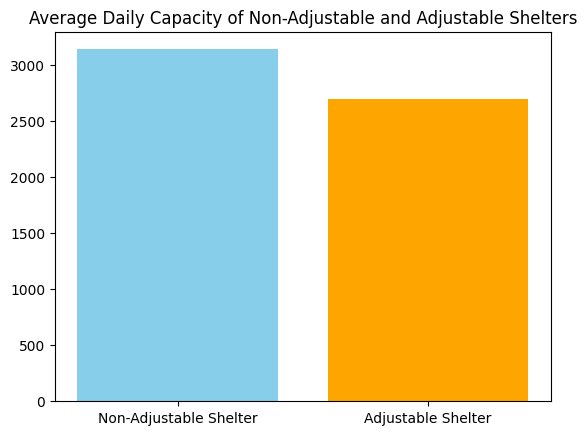

In [545]:
bar_positions = [0, 1]
bar_heights = [capacity_non_adjustable_shelter, capacity_adjustable_shelter]
bar_colors = ['skyblue', 'orange']

plt.bar(bar_positions, bar_heights, color=bar_colors)
plt.xticks(bar_positions, ['Non-Adjustable Shelter', 'Adjustable Shelter'])

plt.title('Average Daily Capacity of Non-Adjustable and Adjustable Shelters')
plt.show()

# Merged dataset 

In [546]:
merged_calls_occupancy_flow_monthly = pd.merge(average_other_daily_capacity, merged_calls_occupancy_flow_monthly, how='inner', left_index=True, right_index=True)

merged_calls_occupancy_flow_monthly[['average_daily_total_calls', 'average_daily_unmatched_callers']] = merged_calls_occupancy_flow_monthly[['average_daily_total_calls', 'average_daily_unmatched_callers']].round(2)
merged_calls_occupancy_flow_monthly.tail()


36

# Historical Analysis of Core Metrics

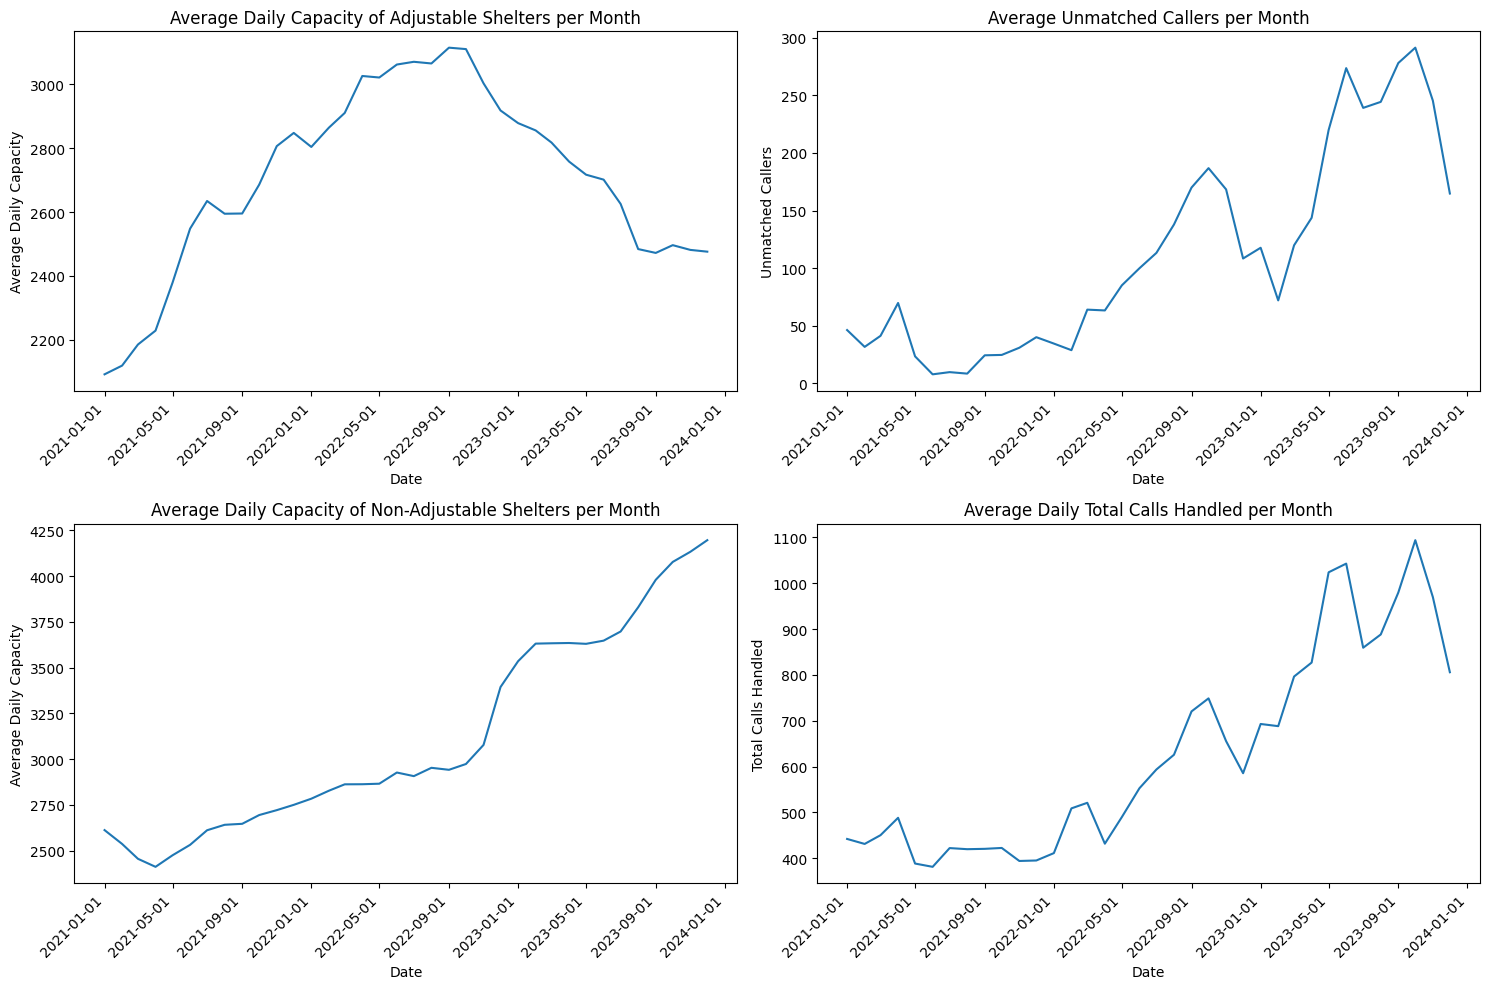

In [547]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

plt.subplot(2, 2, 1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot1 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_adjustable_capacity')
    plot1.set_xticks(plot1.get_xticks())  # Set the x-axis tick positions
    plot1.set_xticklabels(plot1.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Average Daily Capacity')
plt.title('Average Daily Capacity of Adjustable Shelters per Month')

plt.subplot(2, 2, 2)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot2 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_unmatched_callers')
    plot2.set_xticks(plot2.get_xticks())  # Set the x-axis tick positions
    plot2.set_xticklabels(plot2.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Unmatched Callers')
plt.title('Average Unmatched Callers per Month')

plt.subplot(2, 2, 3)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot3 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_nonadjustable_capacity')
    plot3.set_xticks(plot3.get_xticks())  # Set the x-axis tick positions
    plot3.set_xticklabels(plot3.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Average Daily Capacity')
plt.title('Average Daily Capacity of Non-Adjustable Shelters per Month')

plt.subplot(2, 2, 4)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot4 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_total_calls')
    plot4.set_xticks(plot4.get_xticks())  # Set the x-axis tick positions
    plot4.set_xticklabels(plot4.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Total Calls Handled')
plt.title('Average Daily Total Calls Handled per Month')

plt.tight_layout()
plt.show()

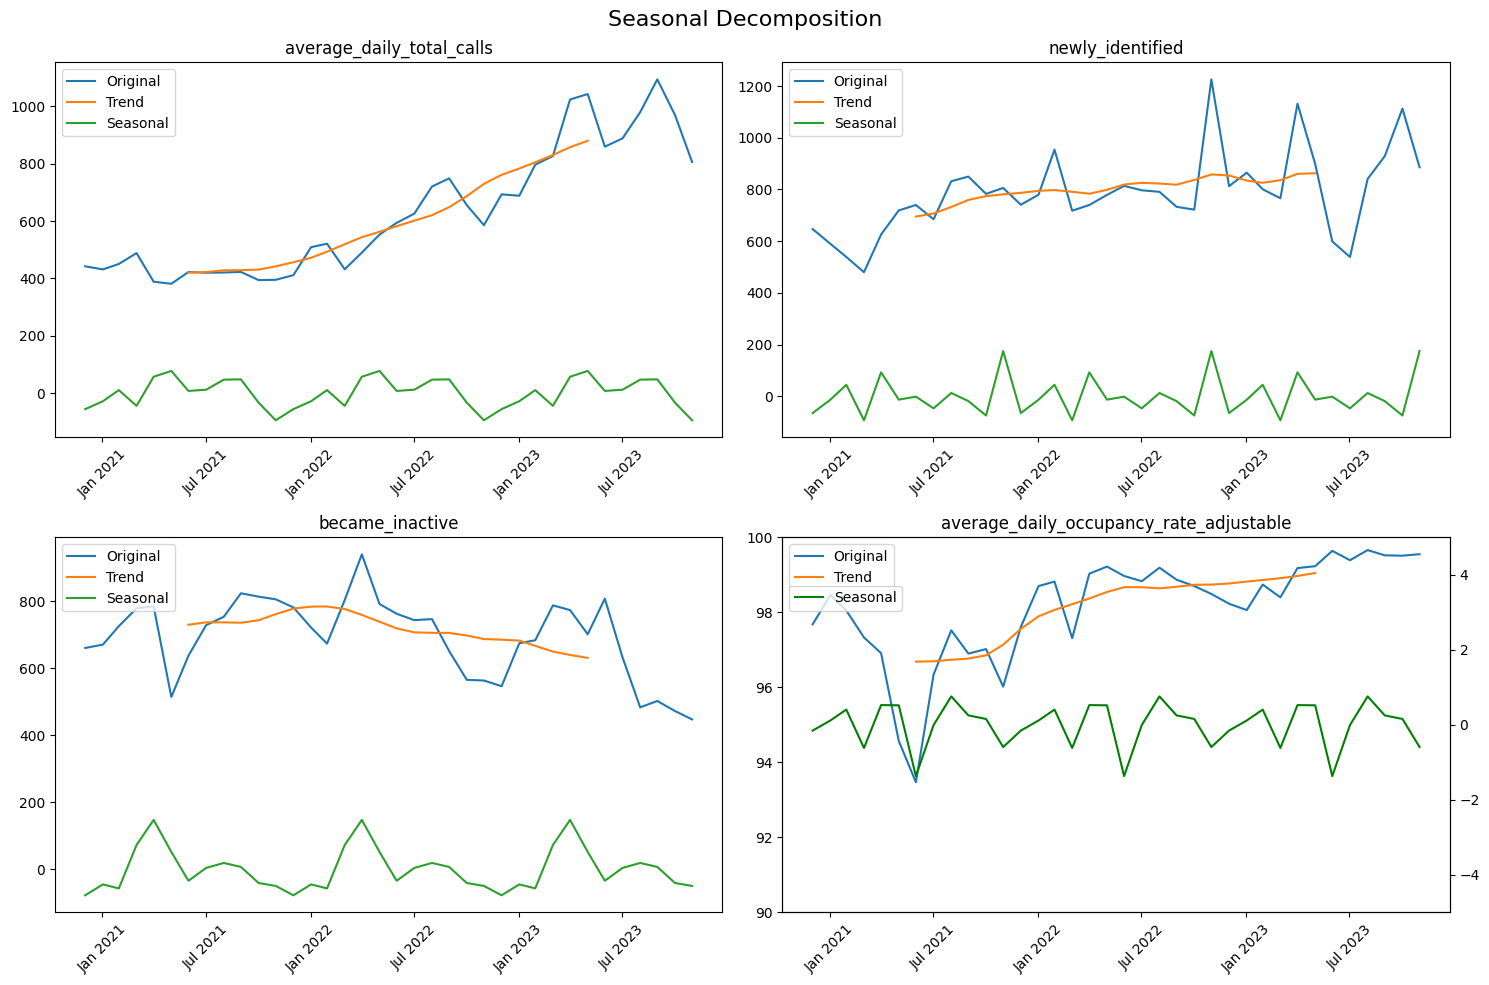

In [548]:
variables = ['average_daily_total_calls', 'newly_identified', 'became_inactive', 'average_daily_occupancy_rate_adjustable']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, variable in enumerate(variables):

    result = seasonal_decompose(merged_calls_occupancy_flow_monthly[variable], period=12)

    axes[i].plot(merged_calls_occupancy_flow_monthly.index, merged_calls_occupancy_flow_monthly[variable], label='Original')
    axes[i].legend()

    axes[i].plot(result.trend.index, result.trend, label='Trend')
    axes[i].legend()

    if i == len(variables) - 1:
        axes[i].set_ylim(90, 100)
        ax2 = axes[i].twinx()
        ax2.plot(result.seasonal.index, result.seasonal, label='Seasonal', color='green')  
        ax2.legend(loc='upper left', bbox_to_anchor=(0.0001, 0.89))
        ax2.set_ylim(-5, 5)  

    else:
        axes[i].plot(result.seasonal.index, result.seasonal, label='Seasonal')
        axes[i].legend(loc='upper left')

    half_year_ticks = pd.date_range(start=result.seasonal.index[0], end=result.seasonal.index[-1], freq='6M')
    axes[i].set_xticks(half_year_ticks)
    axes[i].set_xticklabels([tick.strftime('%b %Y') for tick in half_year_ticks], rotation=45)

    axes[i].set_title(f'{variable}')

fig.suptitle('Seasonal Decomposition', fontsize=16)

plt.tight_layout()
plt.show()


newly_identified – people who entered the shelter system for the first time. We see a constant rate of shelters inflow here <br>
became_inactive – people who were using the shelter system previously, but have not used the shelter system in the past three months.<br><br>
Seasonality is not correlated with the average number of calls. However, it is correlated with the demand for shelters – we see the spikes in the number of newly_identified shelter users in winter months; conversely, the highest number of people who stopped using shelters is observed during the summer monhts.<br><br>
Seasonality is also somewhat correlated with the adjustable occupancy rate: 17.3% compared to 2.4% for nonadjustable. This could mean that the city does indeed adjust the capacity in response to change of seasons.

# T-tests

average_daily_total_calls: 
t-statistic: -6.88893413600925
p-value: 1.7353481576535172e-07 

average_daily_unmatched_callers: 
t-statistic: -4.61201517413596
p-value: 8.006545614428855e-05 

newly_identified: 
t-statistic: 0.16602987177514428
p-value: 0.8693265141990705 

became_inactive: 
t-statistic: -5.459332384784218
p-value: 7.913462469177361e-06 

returned_to_shelter: 
t-statistic: 9.903443022198156
p-value: 1.1918615747542516e-10 

average_daily_occupancy_rate_adjustable: 
t-statistic: -0.44383746320281786
p-value: 0.6605712129084421 

actively_homeless: 
t-statistic: 4.384850381562366
p-value: 0.00014862087847395002 



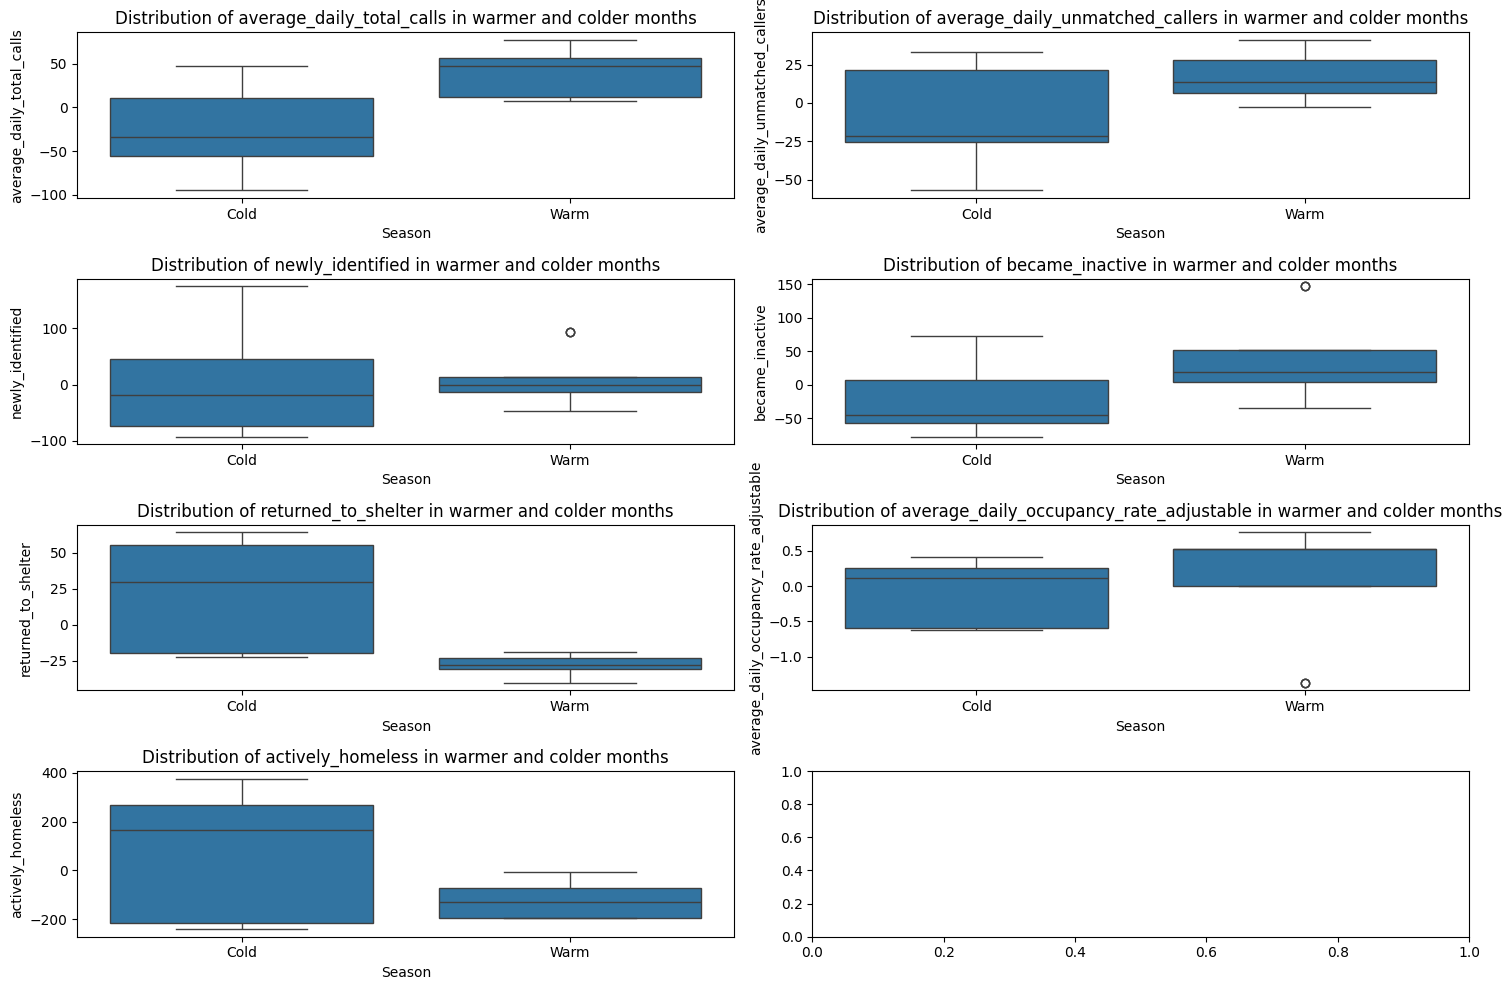

In [549]:
variables = ['average_daily_total_calls', 'average_daily_unmatched_callers', 'newly_identified', 'became_inactive', 'returned_to_shelter', 'average_daily_occupancy_rate_adjustable', 'actively_homeless']

fig, axes = plt.subplots(4, 2, figsize=(15, 10))

axes = axes.flatten()

for i, variable in enumerate(variables):

    result = seasonal_decompose(merged_calls_occupancy_flow_monthly[variable])
    seasonal_data = pd.DataFrame({variable: result.seasonal})
    seasonal_data['Month'] = seasonal_data.index.month

    cold_months = [11, 12, 1, 2,3]
    warm_months = [5, 6, 7, 8,9]

    winter_values = seasonal_data[seasonal_data['Month'].isin(cold_months)][variable]
    summer_values = seasonal_data[seasonal_data['Month'].isin(warm_months)][variable]

    t_statistic, p_value = ttest_ind(winter_values, summer_values)

    seasonal_data['Season'] = np.where(seasonal_data['Month'].isin(warm_months), 'Warm', 'Cold')
    seasonal_data['Season'] = np.where(seasonal_data['Month'].isin(cold_months), 'Cold', seasonal_data['Season'])

    sns.boxplot(x='Season', y=variable, data=seasonal_data, order=['Cold', 'Warm'], ax=axes[i])
    axes[i].set_title(f'Distribution of {variable} in warmer and colder months')

    print(f"{variable}: \nt-statistic: {t_statistic}")
    print("p-value:", p_value, "\n")

plt.tight_layout()
plt.show()

The inflow of newly identified homeless people is approximately the same both in winter and summer. However, we can recognize a pattern of outflow and inflow of people who have used shelters at least once in warm and cold months respectively. That can explain the seasonal fluctuations in the number of actively homeless people.

Otherwise, seasonality can be associated the demand for shelters, albeit in an unexpected manner: we observe more calls made in warmer months compared to colder months. Similarly, the higher number of people get refused a shelter bed during the warmer months compared to winter months.

The disadvantage we have with this merged dataset is the limited number of datapoints due to the short history (only 3 years) of data collection, which results in only 36 monthly observations. 

In [930]:
len(merged_calls_occupancy_flow_monthly)


28

# Creating a model

In [1046]:
merged_calls_daily = pd.merge(calls, calls_full, on = 'Date', how='inner')
merged_calls_daily = merged_calls_daily[['Unmatched callers', 'total_calls_handled']]

daily_average_occupancy_rate = concatenated_occupancy.groupby(concatenated_occupancy.index.date)['occupancy_rate'].mean().round(2)

merged_calls_occupancy_daily = pd.merge(daily_average_occupancy_rate, merged_calls_daily, left_index=True, right_index=True, how='inner')

merged_calls_occupancy_daily['cold_season'] = merged_calls_occupancy_daily.index.month.isin([11, 12, 1, 2, 3]).astype(int)

merged_calls_occupancy_daily.head()

len(merged_calls_occupancy_daily)

1095

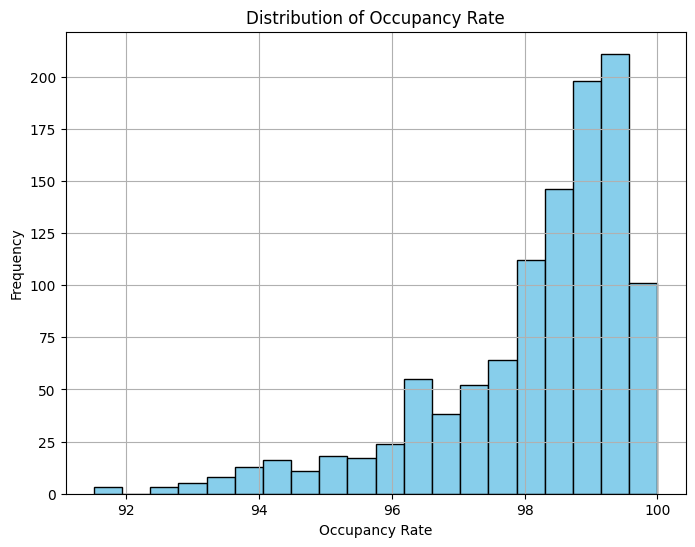

In [1047]:
plt.figure(figsize=(8, 6))
plt.hist(merged_calls_occupancy_daily['occupancy_rate'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Occupancy Rate')
plt.xlabel('Occupancy Rate')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [1048]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


X = merged_calls_occupancy_daily[['Unmatched callers', 'total_calls_handled', 'cold_season']]
y = merged_calls_occupancy_daily['occupancy_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
#print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
#print("R-squared (R2) Score:", r2)
# Step 6: Optionally fine-tune the model parameters (not shown here)

# Step 7: Use the trained model to make predictions
# Example prediction
new_data = [[20, 300, 1]]  # Example input: Unmatched callers=20, total_calls_handled=300, cold_season=1
predicted_occupancy_rate = model.predict(new_data)
print("Predicted Occupancy Rate:", predicted_occupancy_rate)


Predicted Occupancy Rate: [97.48433879]


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


need to add: average total calls last week, average total calls last month, temperature, last month newly identified, became inactive, etc.

In [1044]:
# Get feature importance (coefficients) from the trained linear regression model
feature_importance = model.coef_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importance
print("Feature Importance:")
print(feature_importance_df)


Feature Importance:
               Feature  Importance
2          cold_season    0.656136
0    Unmatched callers    0.011496
1  total_calls_handled    0.000053
